N-Beats Implementation on Electricity Load data

In [1]:
pip install mxnet-cu102 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.8/380.8 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [2]:
pip install "gluonts[mxnet]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.4 MB/s eta 0:00:00


In [3]:
# import all necessary libraries
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.model.n_beats import NBEATSEstimator
from gluonts.mx.trainer import Trainer
import numpy as np
import matplotlib as mb
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from tqdm.autonotebook import tqdm
from gluonts.evaluation import Evaluator

/usr/local/lib/python3.9/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
<ipython-input-3-5a8f482e0d5a>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# electricity consumption of 370 houses from uci

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip

--2023-04-04 16:22:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261335609 (249M) [application/x-httpd-php]
Saving to: ‘LD2011_2014.txt.zip’

LD2011_2014.txt.zip 100%[===================>] 249.23M  18.8MB/s    in 14s     

2023-04-04 16:23:12 (17.4 MB/s) - ‘LD2011_2014.txt.zip’ saved [261335609/261335609]



In [5]:
#Unzip the data from source
!unzip LD2011_2014.txt.zip

Archive:  LD2011_2014.txt.zip
  inflating: LD2011_2014.txt         
   creating: __MACOSX/
  inflating: __MACOSX/._LD2011_2014.txt  


In [6]:
#Display sample records
!head LD2011_2014.txt

"";"MT_001";"MT_002";"MT_003";"MT_004";"MT_005";"MT_006";"MT_007";"MT_008";"MT_009";"MT_010";"MT_011";"MT_012";"MT_013";"MT_014";"MT_015";"MT_016";"MT_017";"MT_018";"MT_019";"MT_020";"MT_021";"MT_022";"MT_023";"MT_024";"MT_025";"MT_026";"MT_027";"MT_028";"MT_029";"MT_030";"MT_031";"MT_032";"MT_033";"MT_034";"MT_035";"MT_036";"MT_037";"MT_038";"MT_039";"MT_040";"MT_041";"MT_042";"MT_043";"MT_044";"MT_045";"MT_046";"MT_047";"MT_048";"MT_049";"MT_050";"MT_051";"MT_052";"MT_053";"MT_054";"MT_055";"MT_056";"MT_057";"MT_058";"MT_059";"MT_060";"MT_061";"MT_062";"MT_063";"MT_064";"MT_065";"MT_066";"MT_067";"MT_068";"MT_069";"MT_070";"MT_071";"MT_072";"MT_073";"MT_074";"MT_075";"MT_076";"MT_077";"MT_078";"MT_079";"MT_080";"MT_081";"MT_082";"MT_083";"MT_084";"MT_085";"MT_086";"MT_087";"MT_088";"MT_089";"MT_090";"MT_091";"MT_092";"MT_093";"MT_094";"MT_095";"MT_096";"MT_097";"MT_098";"MT_099";"MT_100";"MT_101";"MT_102";"MT_103";"MT_104";"MT_105";"MT_106";"MT_107";"MT_108";"MT_109";"MT_110";"MT_111

In [7]:
# In order to process the data loaded it in to a data frame
load_data_frame=pd.read_csv("LD2011_2014.txt",delimiter=";",index_col=0,parse_dates=True,decimal=",")

In [8]:
load_data_frame

MT_001     MT_002    MT_003      MT_004     MT_005  \
2011-01-01 00:15:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 00:30:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 00:45:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 01:00:00  0.000000   0.000000  0.000000    0.000000   0.000000   
2011-01-01 01:15:00  0.000000   0.000000  0.000000    0.000000   0.000000   
...                       ...        ...       ...         ...        ...   
2014-12-31 23:00:00  2.538071  22.048364  1.737619  150.406504  85.365854   
2014-12-31 23:15:00  2.538071  21.337127  1.737619  166.666667  81.707317   
2014-12-31 23:30:00  2.538071  20.625889  1.737619  162.601626  82.926829   
2014-12-31 23:45:00  1.269036  21.337127  1.737619  166.666667  85.365854   
2015-01-01 00:00:00  2.538071  19.914651  1.737619  178.861789  84.146341   

                         MT_006     MT_007      MT_008     MT_009     MT_010  \
2011-01-01 00:15:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 00:30:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 00:45:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 01:00:00    0.000000   0.000000    0.000000   0.000000   0.000000   
2011-01-01 01:15:00    0.000000   0.000000    0.000000   0.000000   0.000000   
...                         ...        ...         ...        ...        ...   
2014-12-31 23:00:00  303.571429  11.305822  282.828283  68.181818  72.043011   
2014-12-31 23:15:00  324.404762  11.305822  252.525253  64.685315  72.043011   
2014-12-31 23:30:00  318.452381  10.175240  242.424242  61.188811  74.193548   
2014-12-31 23:45:00  285.714286  10.175240  225.589226  64.685315  72.043011   
2015-01-01 00:00:00  279.761905  10.175240  249.158249  62.937063  69.892473   

                     ...      MT_361   MT_362       MT_363       MT_364  \
2011-01-01 00:15:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 00:30:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 00:45:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 01:00:00  ...    0.000000      0.0     0.000000     0.000000   
2011-01-01 01:15:00  ...    0.000000      0.0     0.000000     0.000000   
...                  ...         ...      ...          ...          ...   
2014-12-31 23:00:00  ...  276.945039  28200.0  1616.033755  1363.636364   
2014-12-31 23:15:00  ...  279.800143  28300.0  1569.620253  1340.909091   
2014-12-31 23:30:00  ...  284.796574  27800.0  1556.962025  1318.181818   
2014-12-31 23:45:00  ...  246.252677  28000.0  1443.037975   909.090909   
2015-01-01 00:00:00  ...  188.436831  27800.0  1409.282700   954.545455   

                        MT_365    MT_366      MT_367      MT_368      MT_369  \
2011-01-01 00:15:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 00:30:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 00:45:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 01:00:00   0.000000  0.000000    0.000000    0.000000    0.000000   
2011-01-01 01:15:00   0.000000  0.000000    0.000000    0.000000    0.000000   
...                        ...       ...         ...         ...         ...   
2014-12-31 23:00:00  29.986962  5.851375  697.102722  176.961603  651.026393   
2014-12-31 23:15:00  29.986962  9.947338  671.641791  168.614357  669.354839   
2014-12-31 23:30:00  27.379400  9.362200  670.763828  153.589316  670.087977   
2014-12-31 23:45:00  26.075619  4.095963  664.618086  146.911519  646.627566   
2015-01-01 00:00:00  27.379400  4.095963  628.621598  131.886477  673.020528   

                          MT_370  
2011-01-01 00:15:00     0.000000  
2011-01-01 00:30:00     0.000000  
2011-01-01 00:45:00     0.000000  
2011-01-01 01:00:00     0.000000  
2011-01-01 01:15:00     0.000000  
...                          ...  
2014-12-31 23:00:00  7621.6216

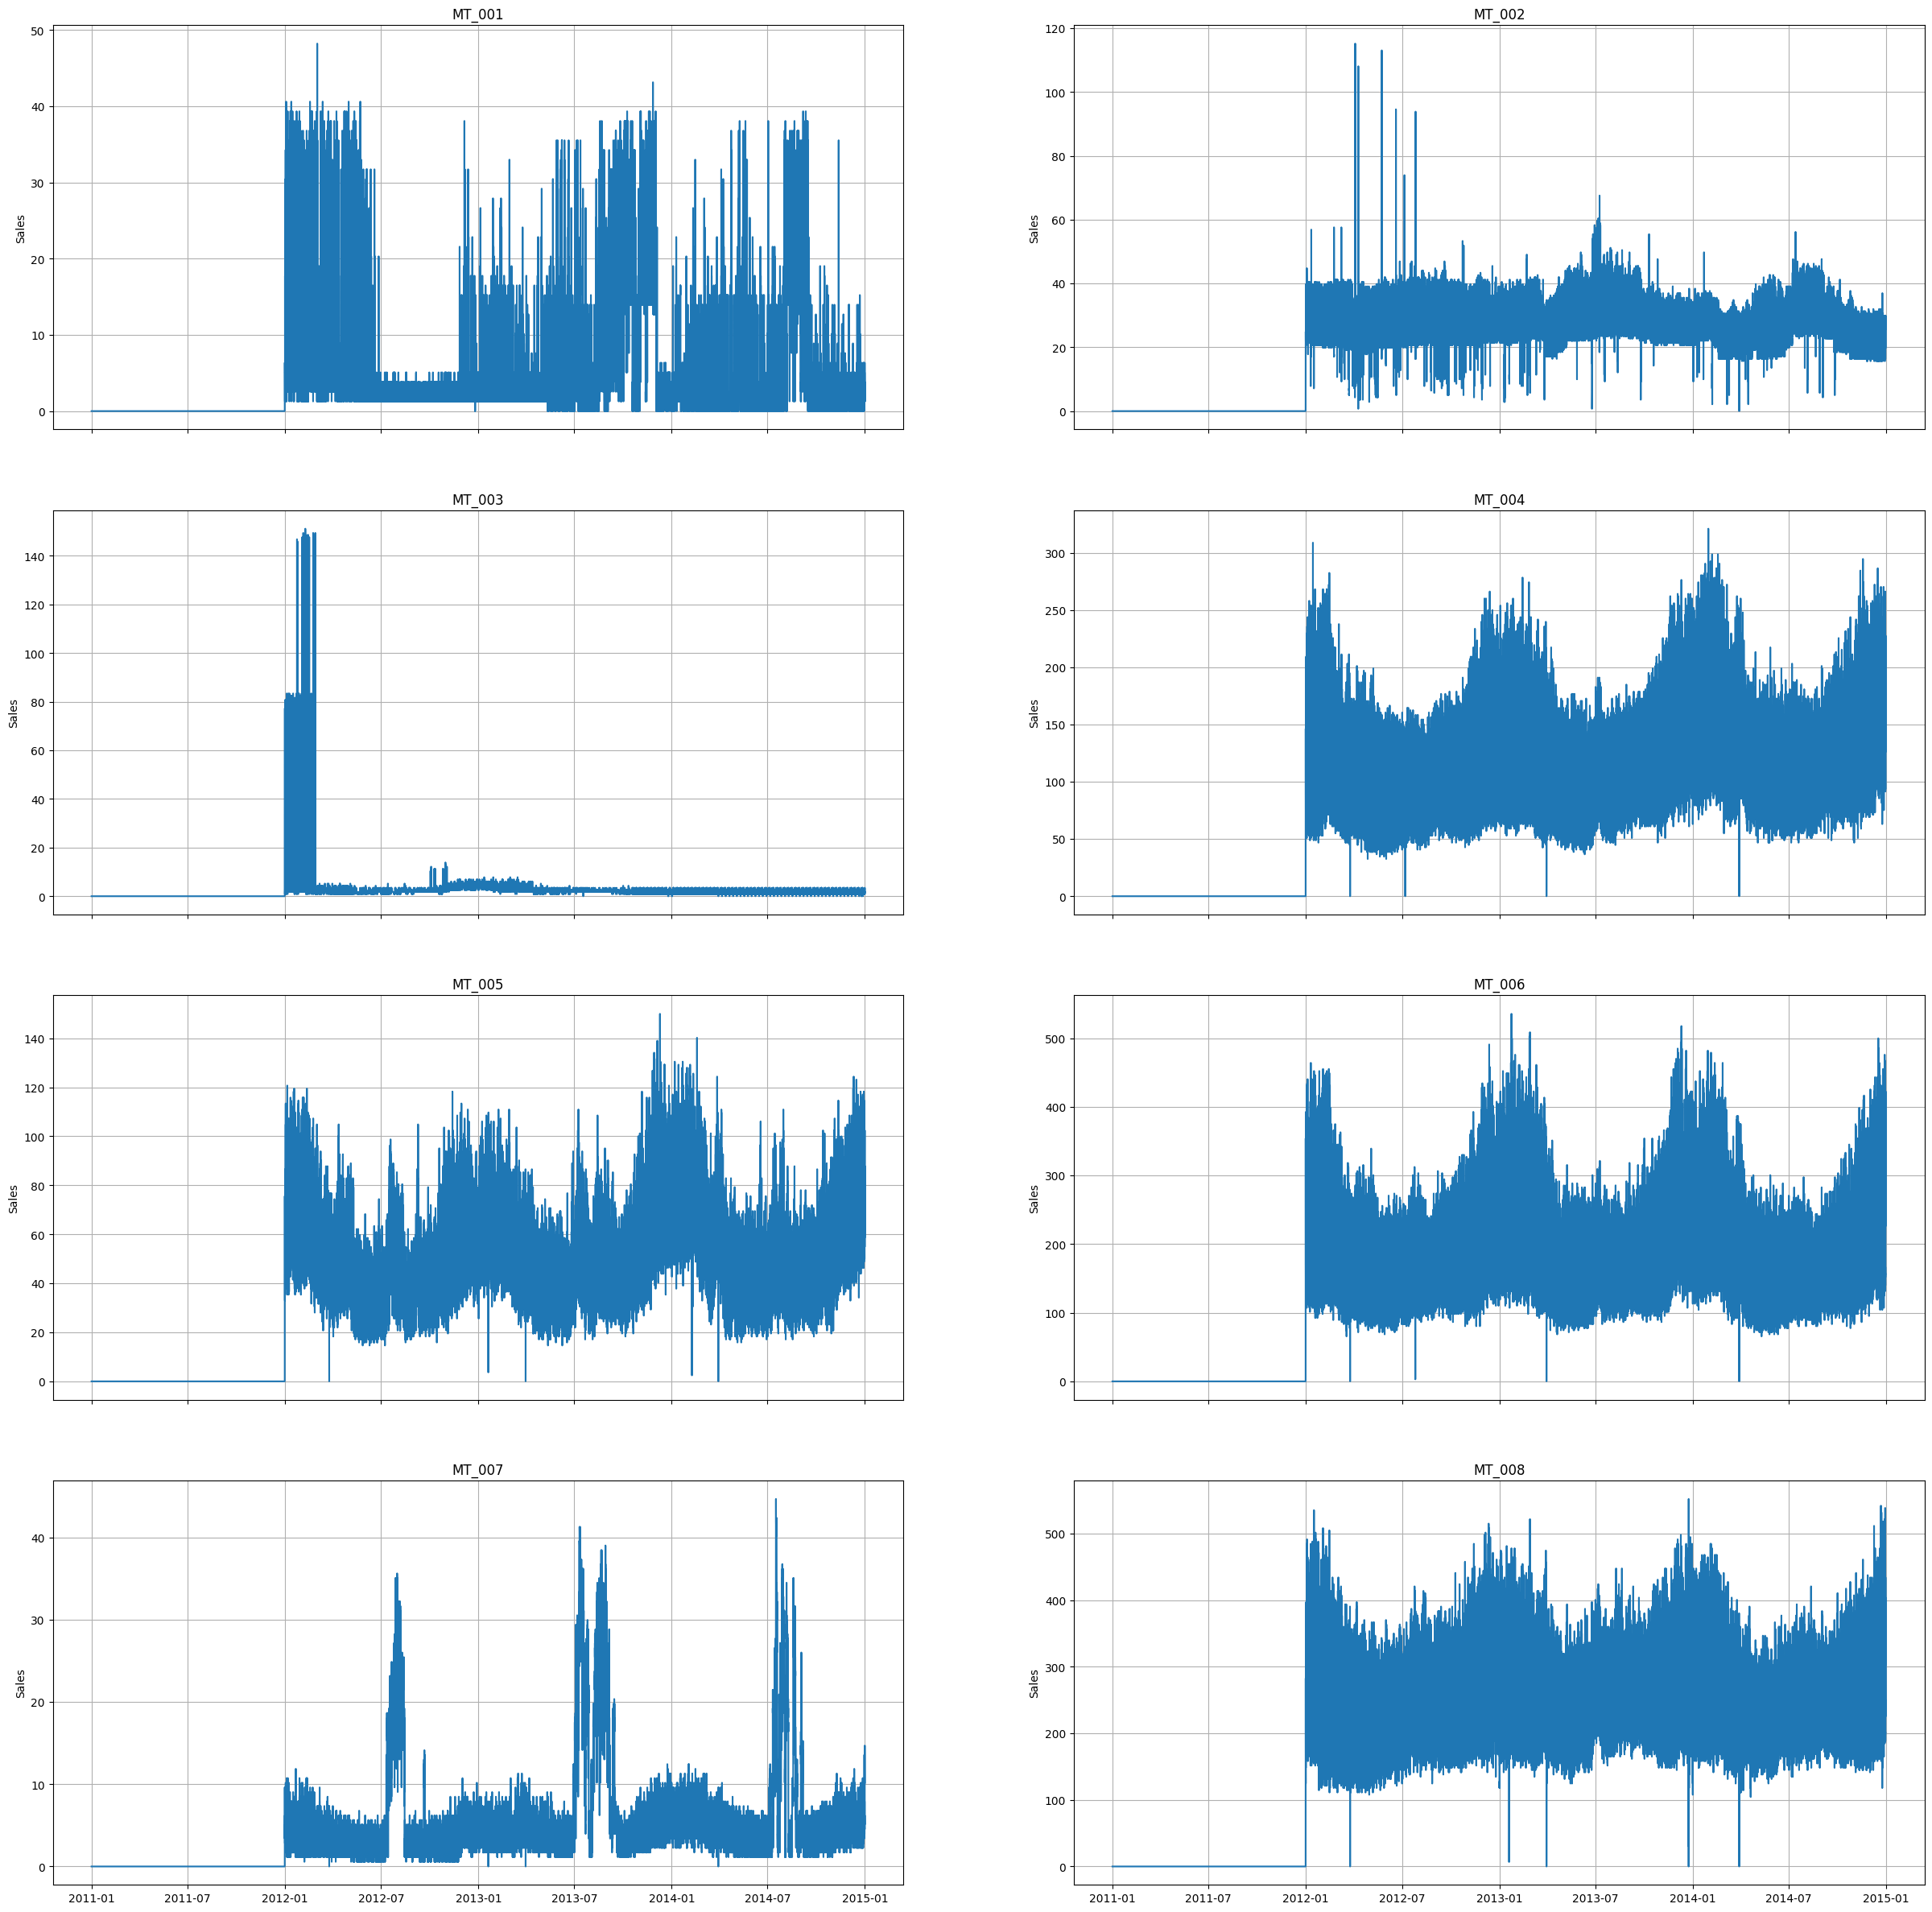

In [9]:
#plots of sample data for a custom range of 0 to 8 electricity time series
plt.rcParams["axes.grid"] = True
fig,ax=plt.subplots(nrows=4,ncols=2,figsize=(30,30),sharex=True)
axes_array=ax.ravel()
for i in range(0,8):
    axes_array[i].plot(load_data_frame.iloc[1:,i])
    axes_array[i].set(title=load_data_frame.iloc[1:,i].name , ylabel="Sales")
    axes_array[i].grid(which='minor',axis='x')

In [10]:
# Transposing the loaded data frame to have individual housholds as rows with time frequency as columns for modeeling purposes in gluonTS
load_data_frame_1=load_data_frame.reset_index(drop=True).T.reset_index()
load_data_frame_1

index    0    1    2    3    4    5    6    7    8  ...       140246  \
0    MT_001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     2.538071   
1    MT_002  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    22.048364   
2    MT_003  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     1.737619   
3    MT_004  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   156.504065   
4    MT_005  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    86.585366   
..      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...          ...   
365  MT_366  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     3.510825   
366  MT_367  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   546.971027   
367  MT_368  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   185.308848   
368  MT_369  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   653.958944   
369  MT_370  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  8594.594595   

          140247       140248       140249       140250       140251  \
0       1.269036     2.538071     2.538071     1.269036     2.538071   
1      22.048364    22.048364    22.048364    22.048364    22.048364   
2       1.737619     1.737619     1.737619     1.737619     1.737619   
3     164.634146   160.569106   162.601626   156.504065   150.406504   
4      93.902439    87.804878    80.487805    85.365854    85.365854   
..           ...          ...          ...          ...          ...   
365     6.436513    11.702750     8.191925     4.681100     5.851375   
366   521.510097   672.519754   719.051800   707.638279   697.102722   
367   173.622705   213.689482   205.342237   188.647746   176.961603   
368   658.357771   711.876833   694.281525   652.492669   651.026393   
369  7891.891892  7945.945946  7351.351351  7189.189189  7621.621622   

          140252       140253       140254       140255  
0       2.538071     2.538071     1.269036     2.538071  
1      21.337127    20.625889    21.337127    19.914651  
2       1.737619     1.737619     1.737619     1.737619  
3     166.666667   162.601626   166.666667   178.861789  
4      81.707317    82.926829    85.365854    84.146341  
..           ...          ...          ...          ...  
365     9.947338     9.362200     4.095963     4.095963  
366   671.641791   670.763828   664.618086   628.621598  
367   168.614357   153.589316   146.911519   131.886477  
368   669.354839   670.087977   646.627566   673.020528  
369  6702.702703  6864.864865  6540.540541  7135.135135  

[370 rows x 140257 columns]

In [11]:
# In order to utilise house hold id's as feature static variable in GluonTS theses column was converted to codes for categorical feature processing.
House_codes=load_data_frame_1["index"].astype('category').cat.codes.values
House_codes

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [12]:
#split the data feame into test and train sets
electric_train=load_data_frame_1.iloc[:,1:138912].values
electric_test=load_data_frame_1.iloc[:,138912:].values

In [13]:
electric_train.shape

(370, 138911)

In [14]:
electric_test.shape

(370, 1345)

In [15]:
# Initilise the variables for deep ar estimator
freq="15min"
start_train = pd.Timestamp("2011-01-01 00:15:00", freq=freq)
start_test = pd.Timestamp("2014-12-18 00:15:00", freq=freq)
prediction_lentgh=96

<ipython-input-15-299e59817d8f>:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_train = pd.Timestamp("2011-01-01 00:15:00", freq=freq)
<ipython-input-15-299e59817d8f>:4: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_test = pd.Timestamp("2014-12-18 00:15:00", freq=freq)


In [16]:
estimator = NBEATSEstimator(
                            freq=freq,
                            stack_types=["G"],
                            prediction_length=96,
                            context_length=960,
                            num_stacks=2,
                            num_blocks=[3, 3],
                            num_block_layers=[4,4],
                            trainer=Trainer(
                            epochs=50,
                            learning_rate=1e-3))

In [17]:
# Convert the data into gluonts list dataset form to input the model
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_train,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(electric_train[0:369],
                             House_codes[0:369].reshape(-1,1))
], freq=freq)

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start_test,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, fsc) in zip(electric_test[0:369],
                            House_codes[0:369].reshape(-1,1))
], freq=freq)

In [18]:
# train the estimator
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:05<00:00,  8.59it/s, epoch=50/50, avg_epoch_loss=0.163]


In [19]:
# Generation of predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  
    predictor=predictor,  
    #num_samples=100, 
)

In [20]:

# Conversion of predictions to a list
print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(electric_test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(electric_test)))

Obtaining time series conditioning values ...


  0%|          | 0/370 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/370 [00:00<?, ?it/s]

In [21]:
forecast_entry = forecasts[1]
type(forecast_entry)

gluonts.model.forecast.SampleForecast

In [22]:
# plot the predictions with probabilistic ranges ( provided in the official documentation of gluonTS )
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_lentgh
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

  0%|          | 0/39 [00:00<?, ?it/s]

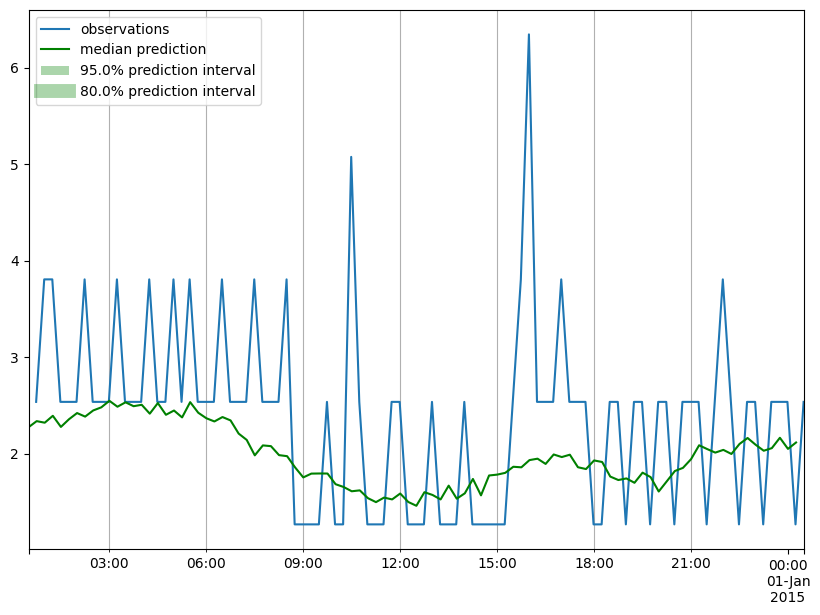

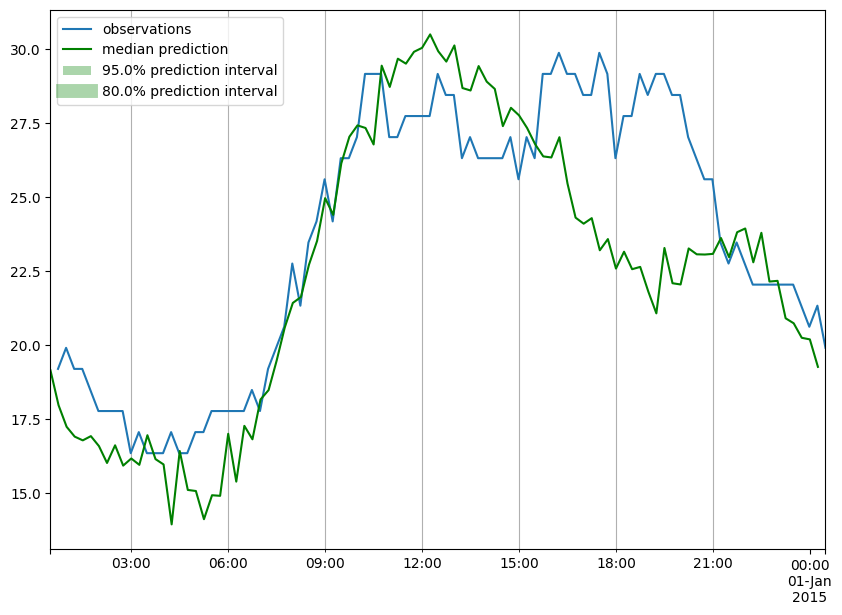

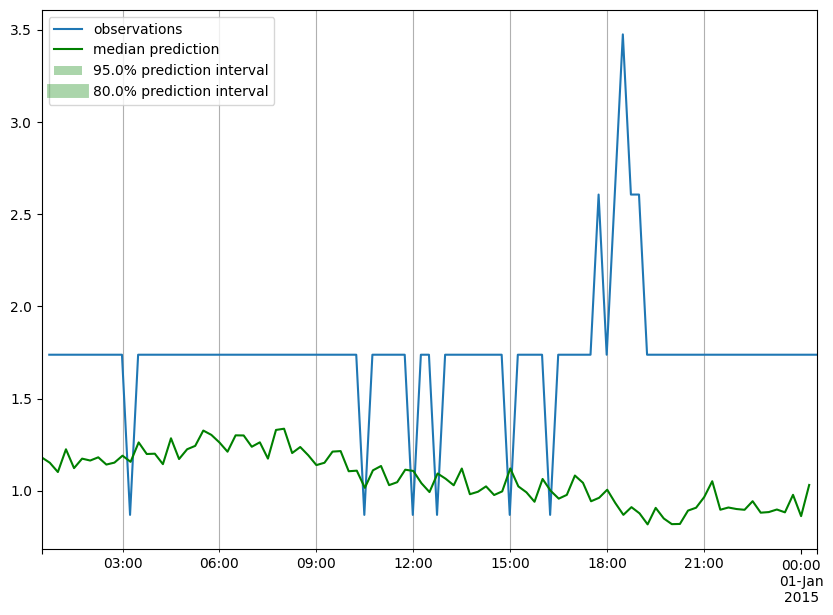

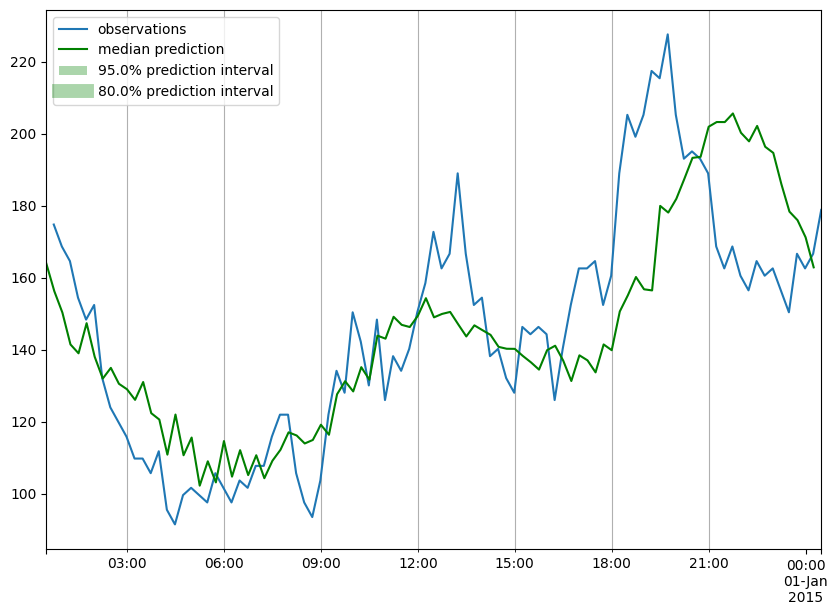

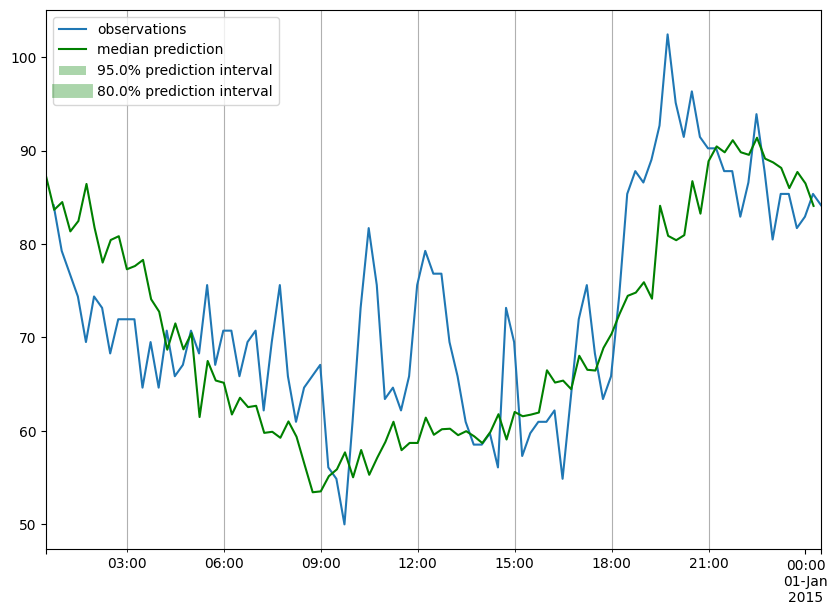

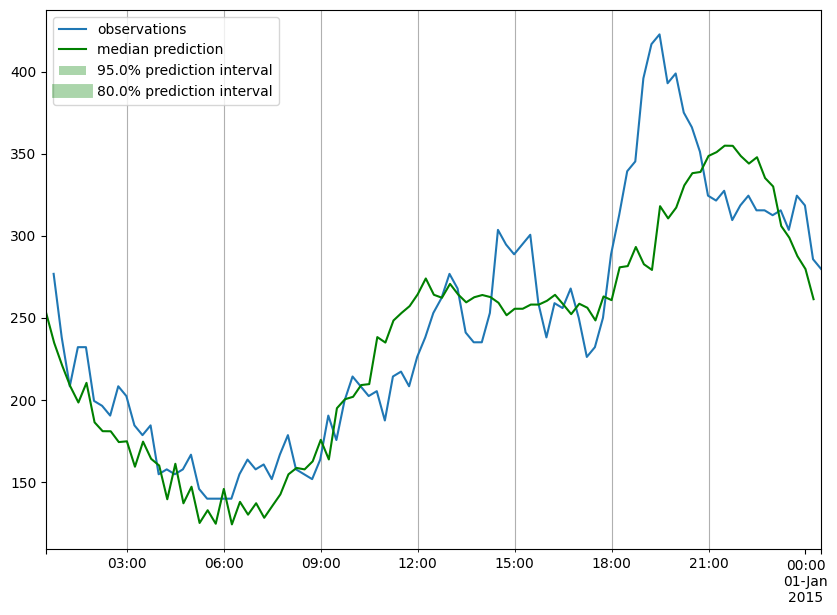

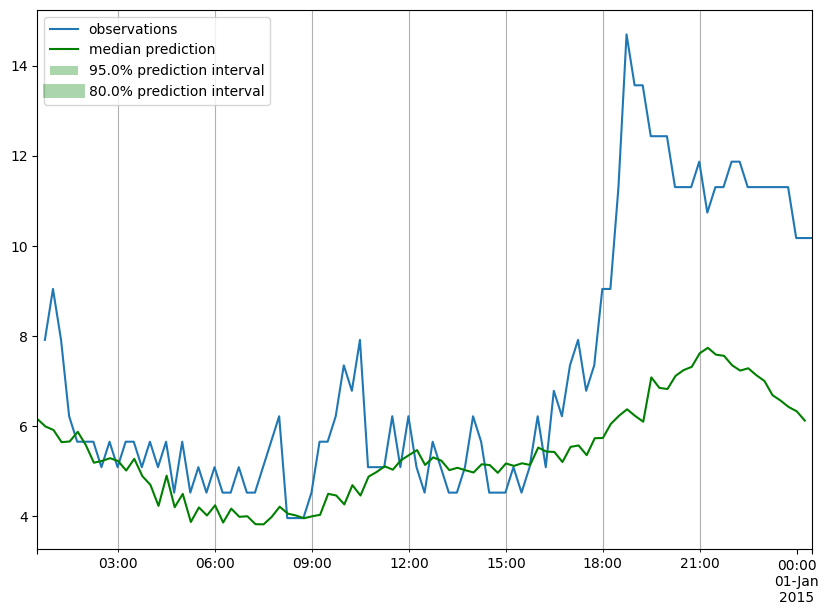

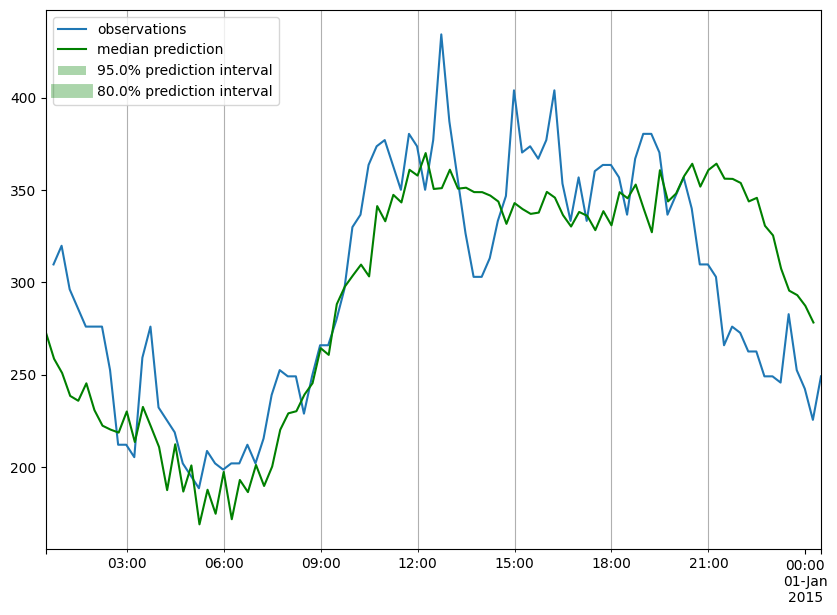

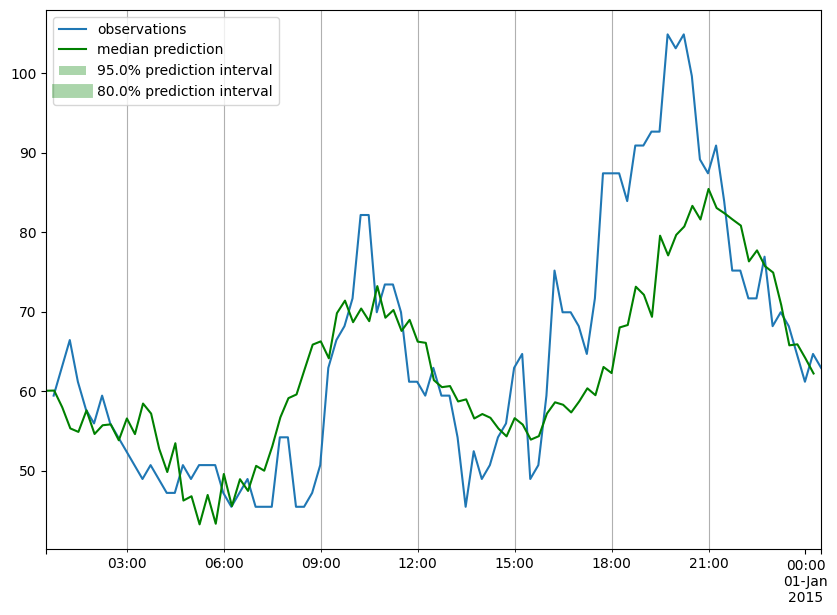

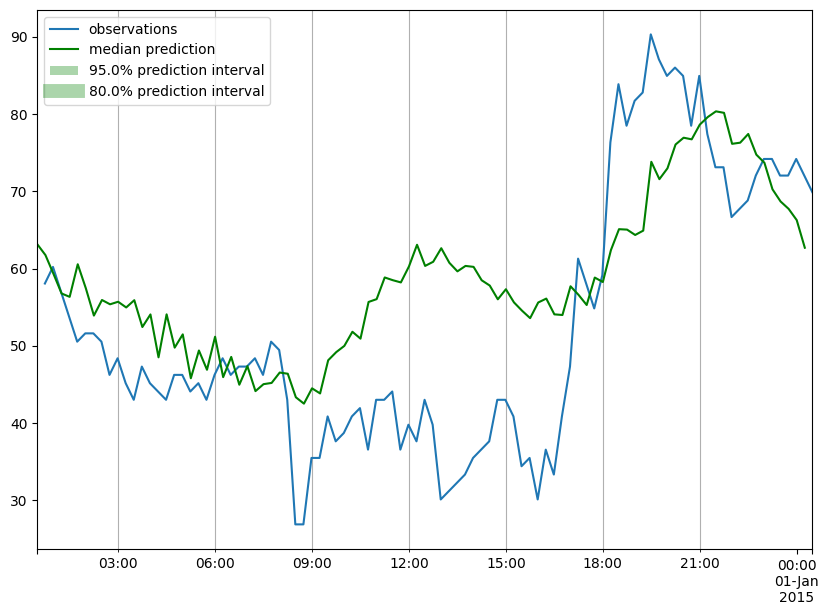

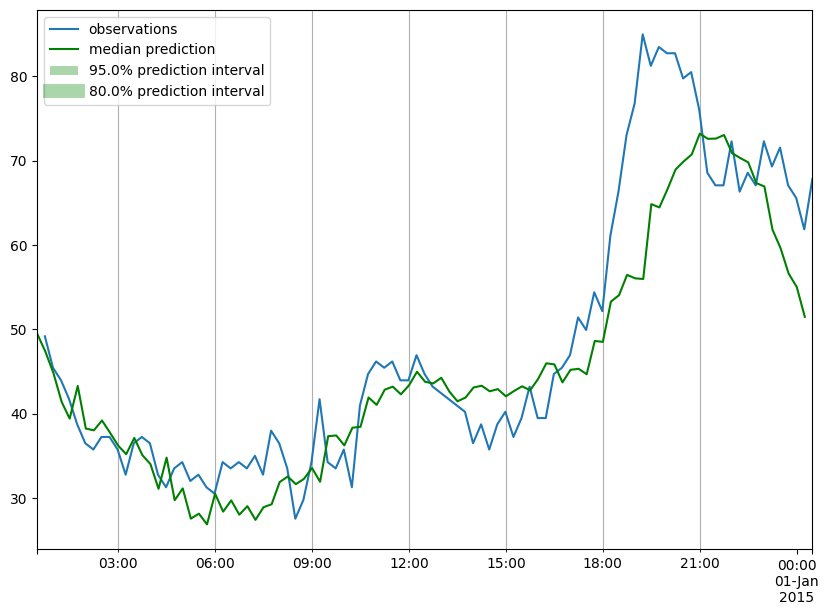

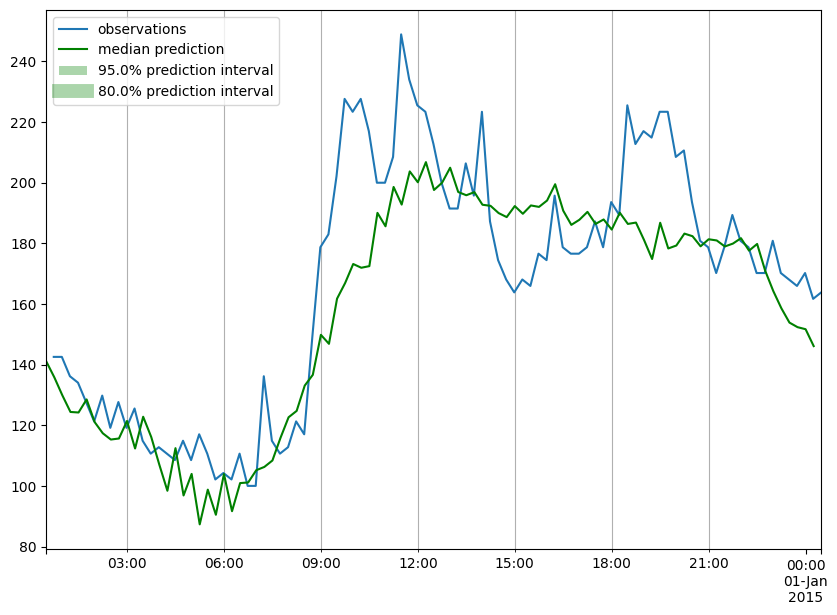

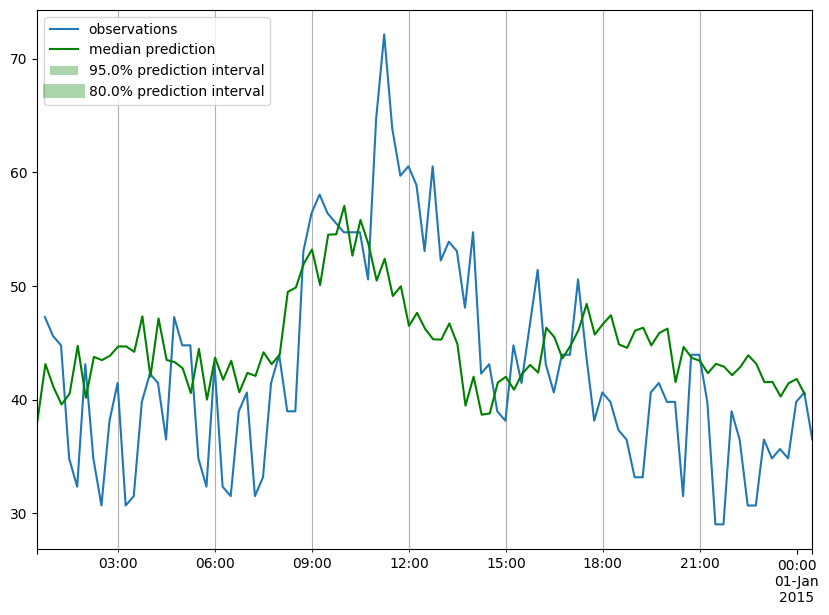

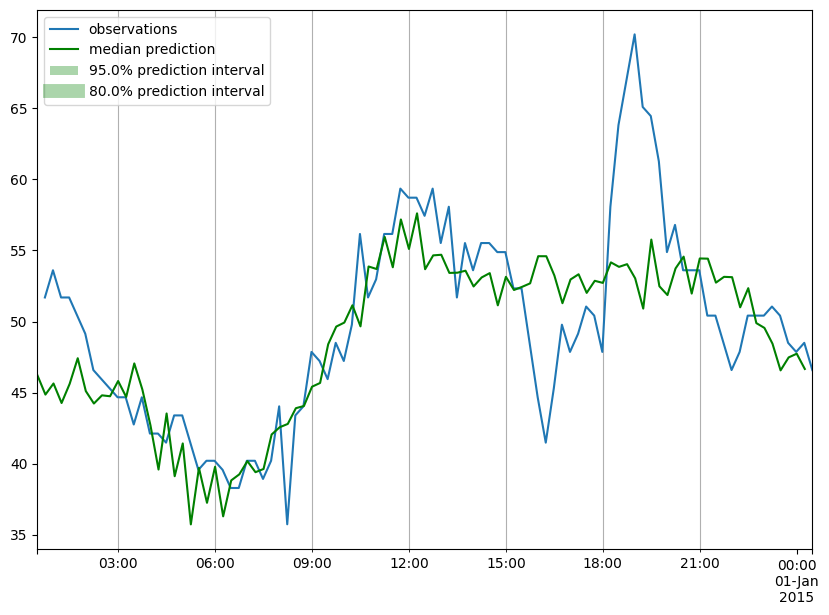

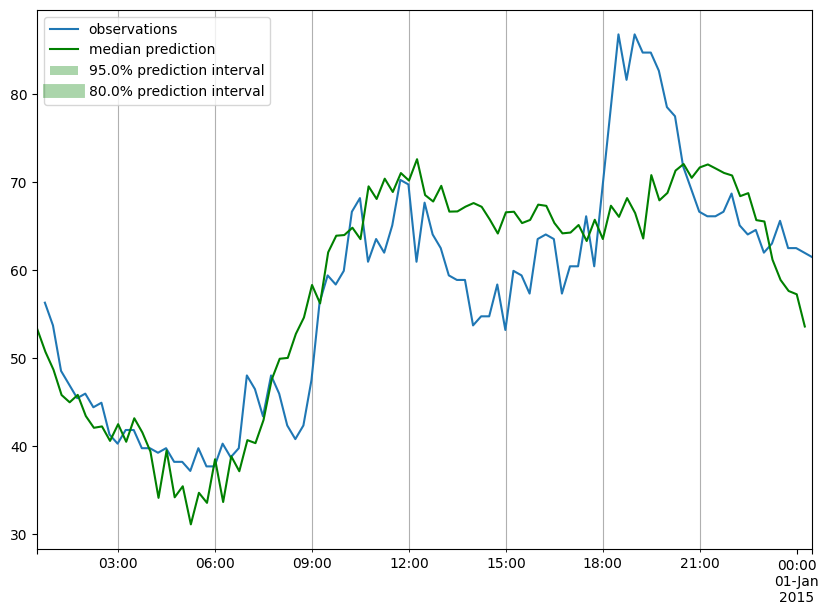

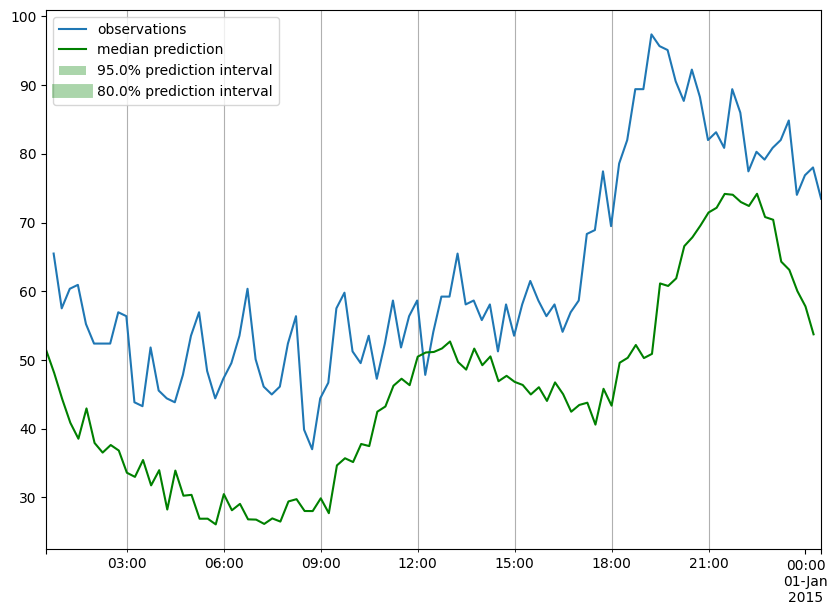

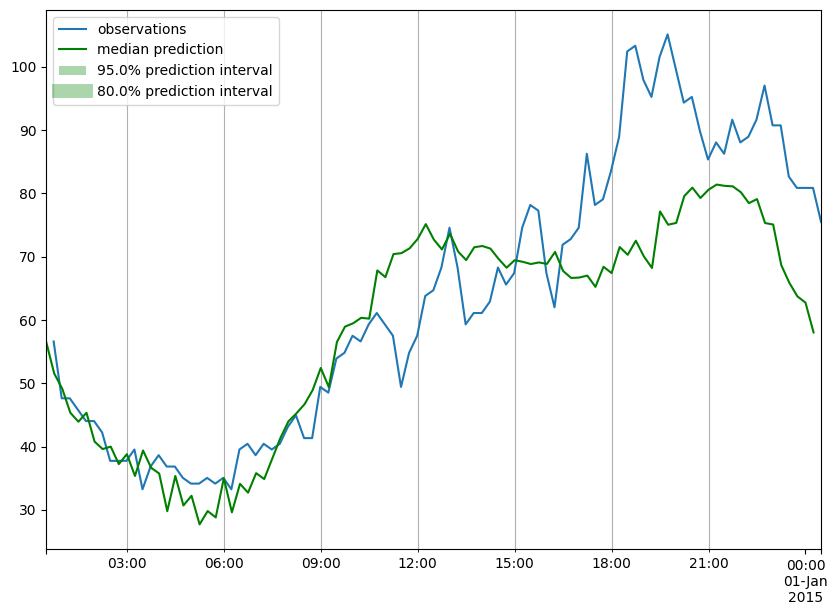

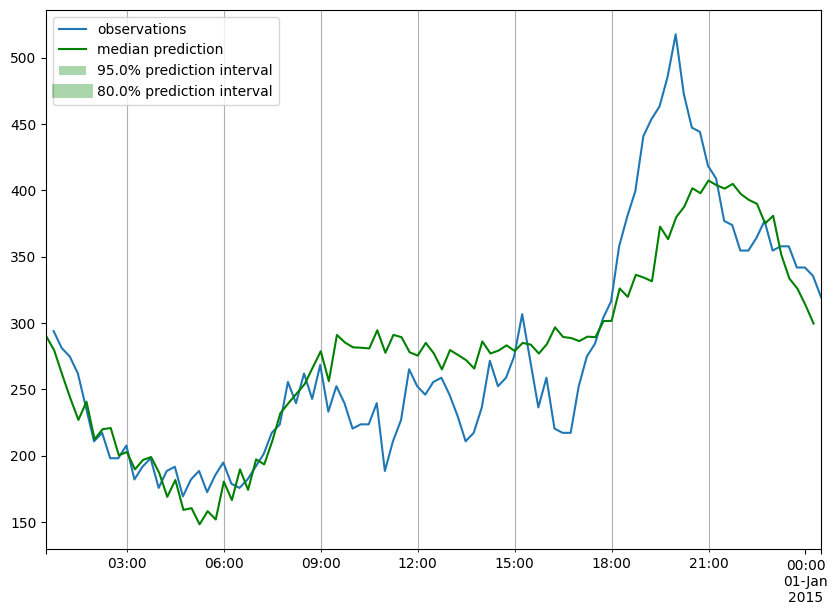

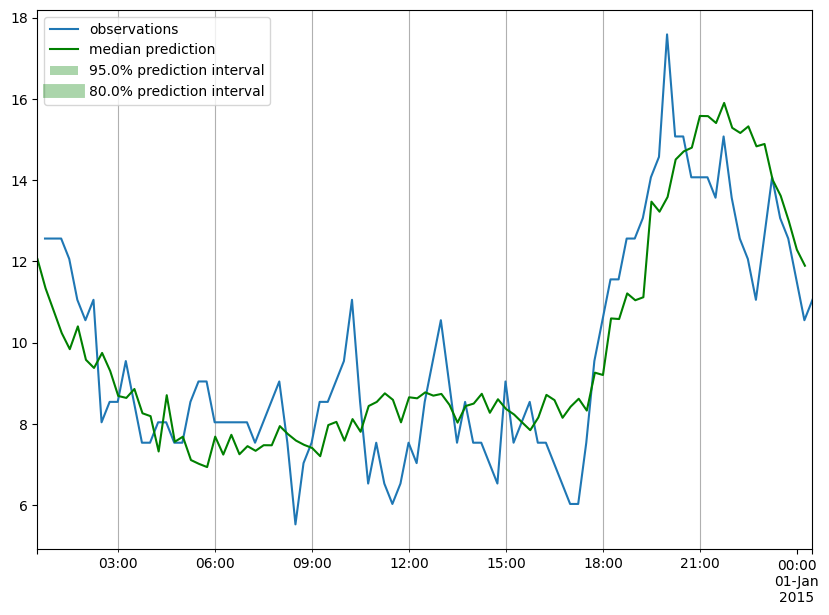

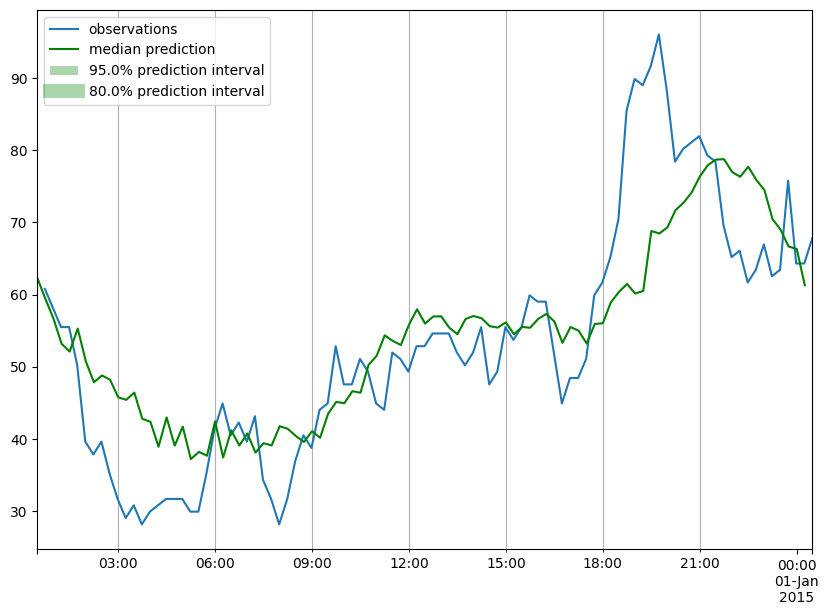

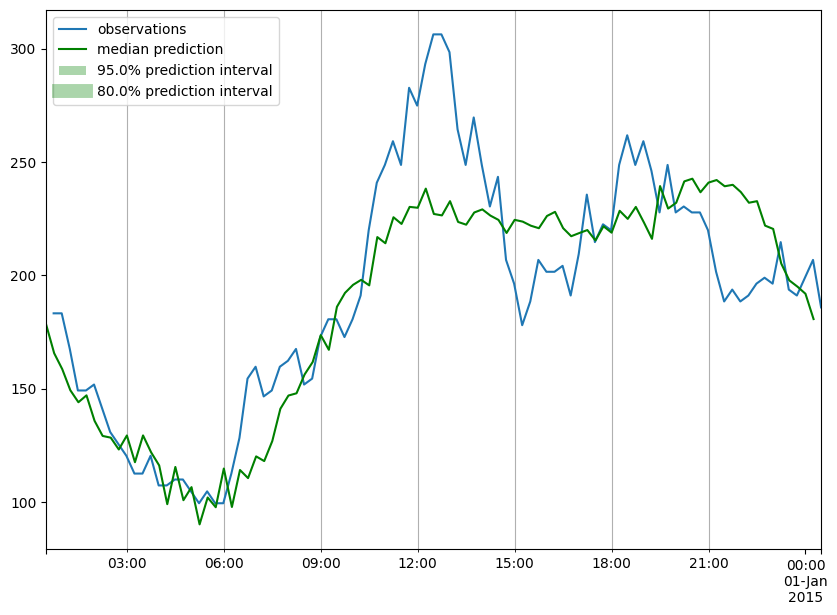

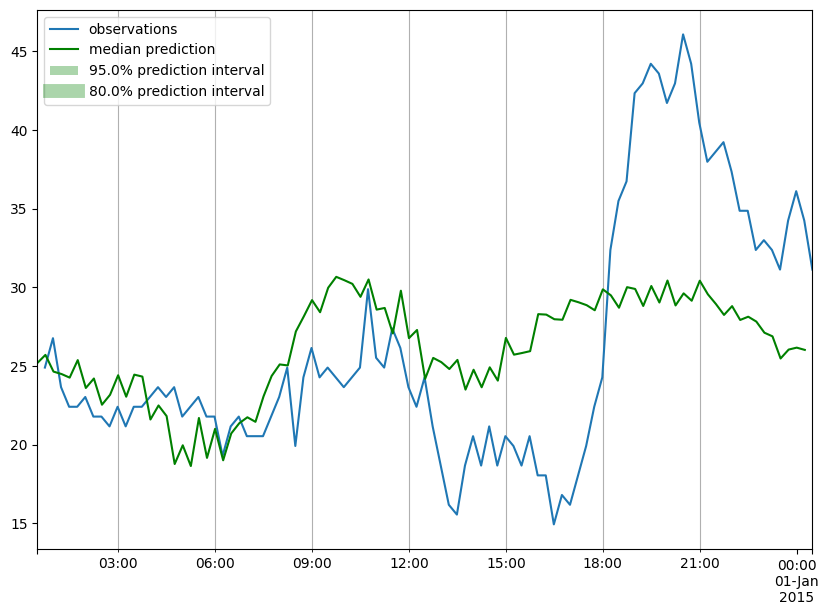

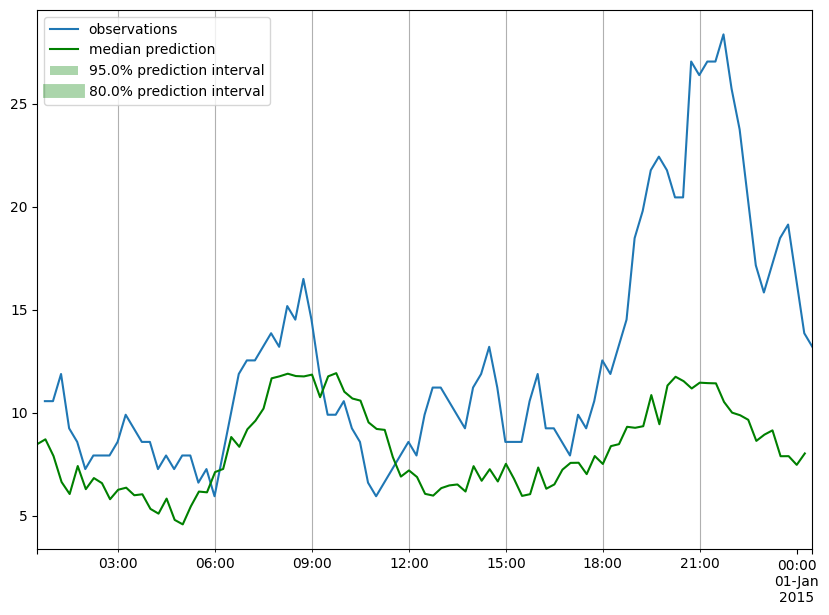

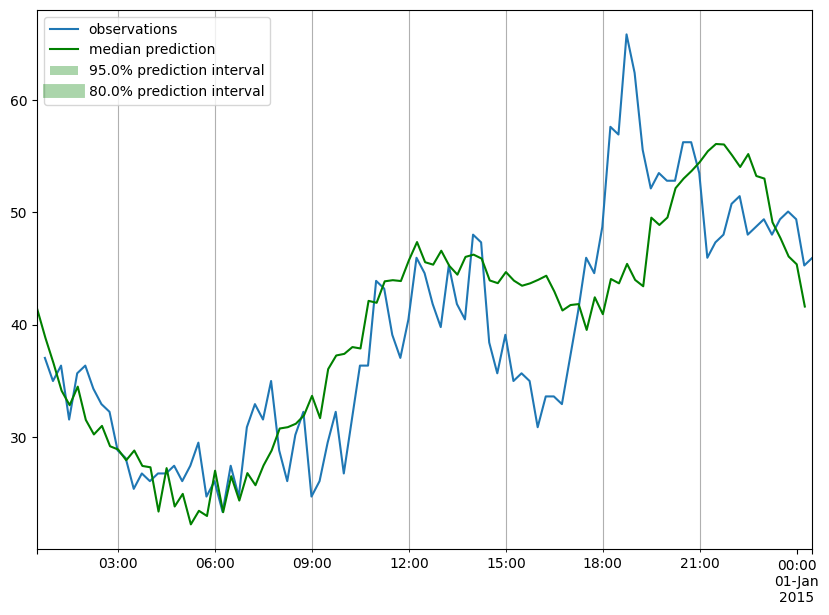

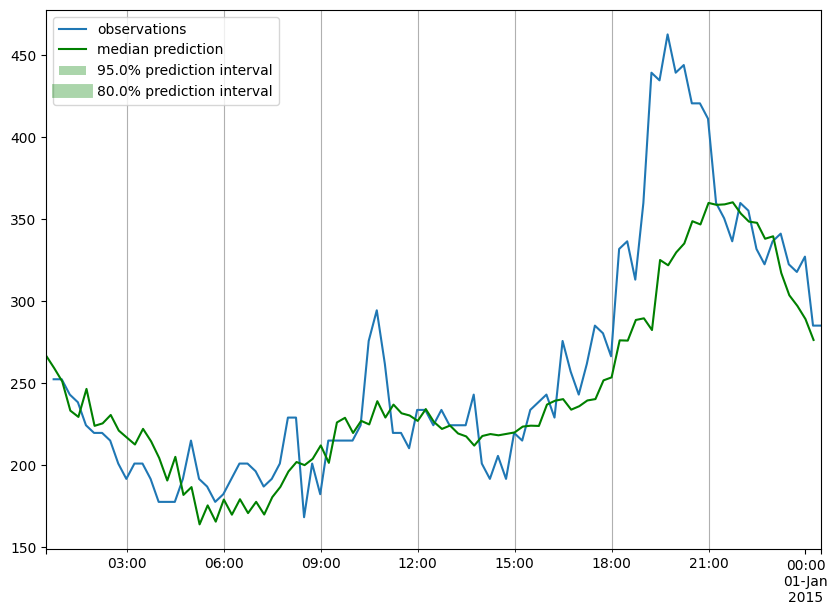

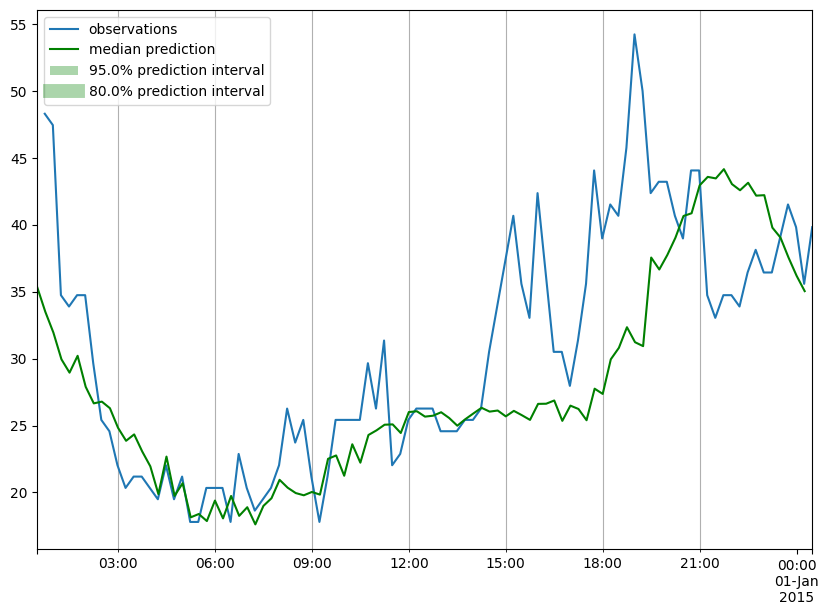

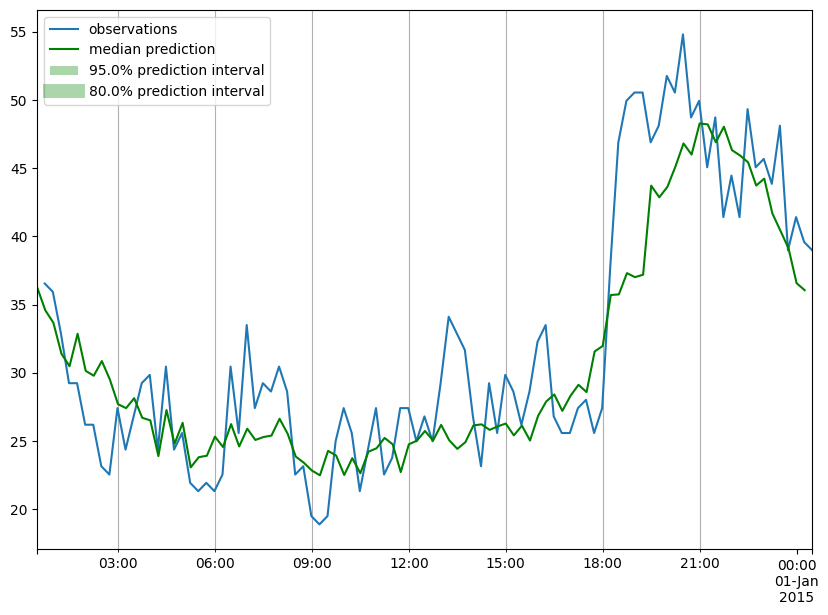

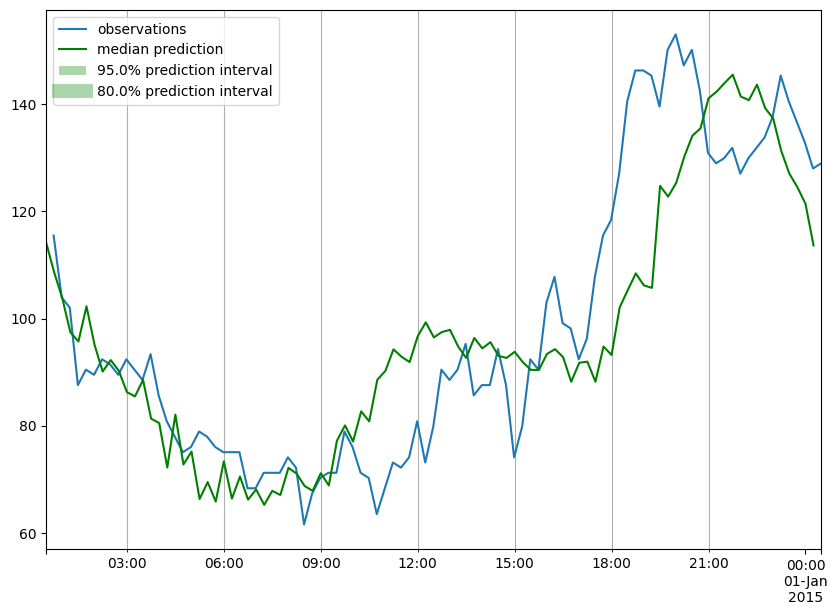

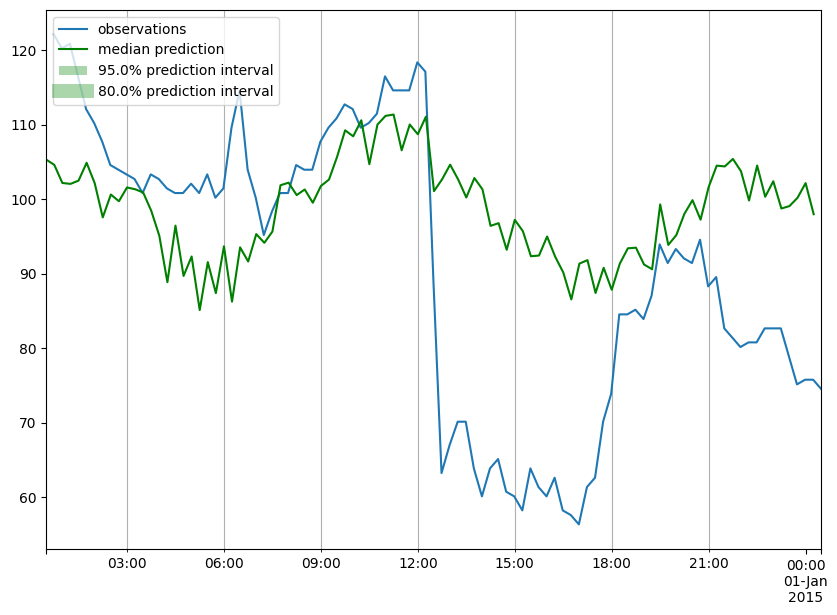

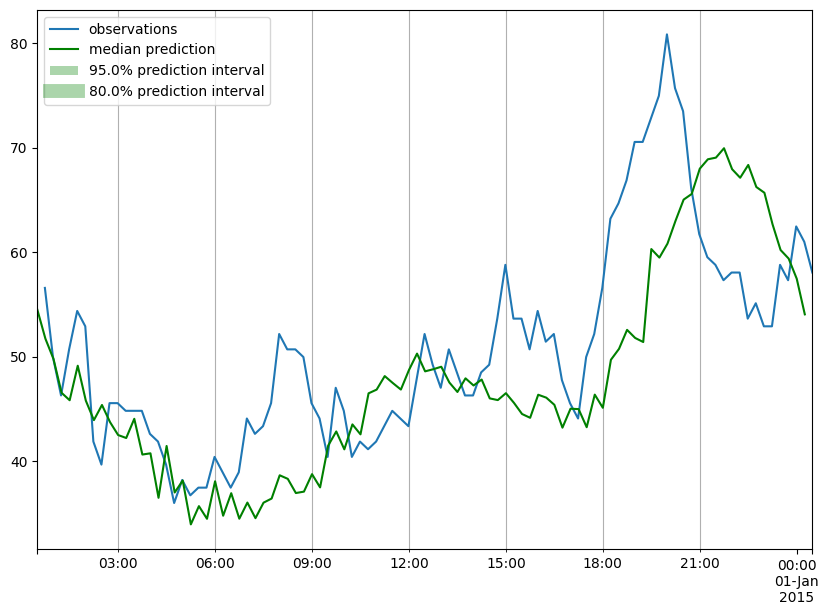

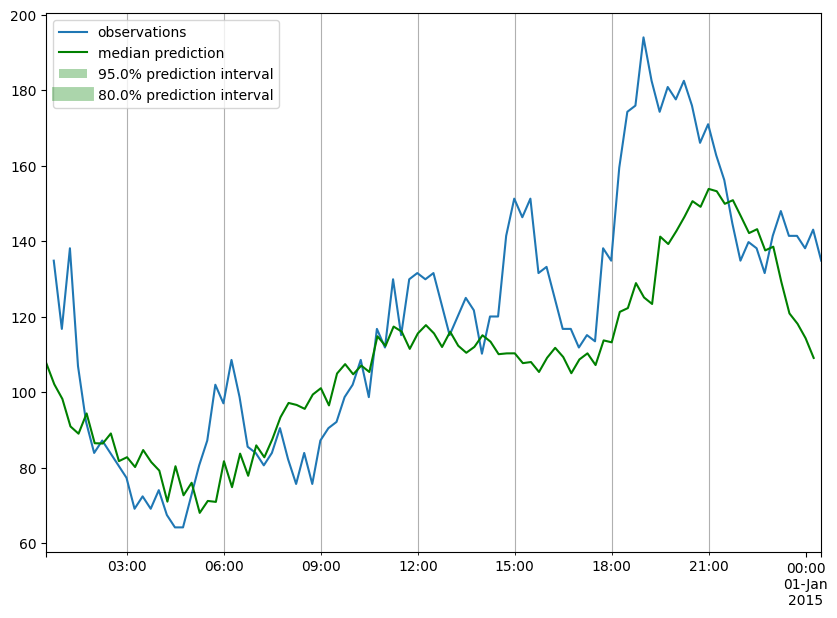

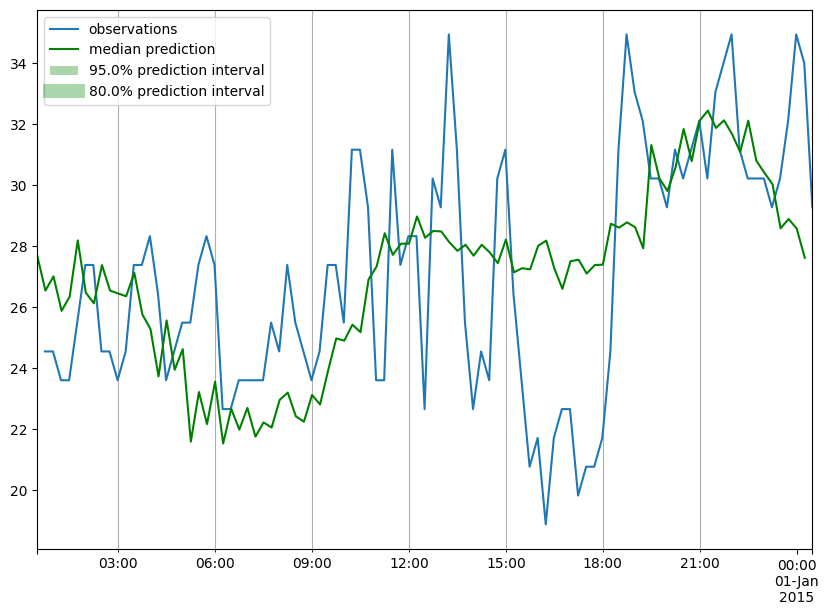

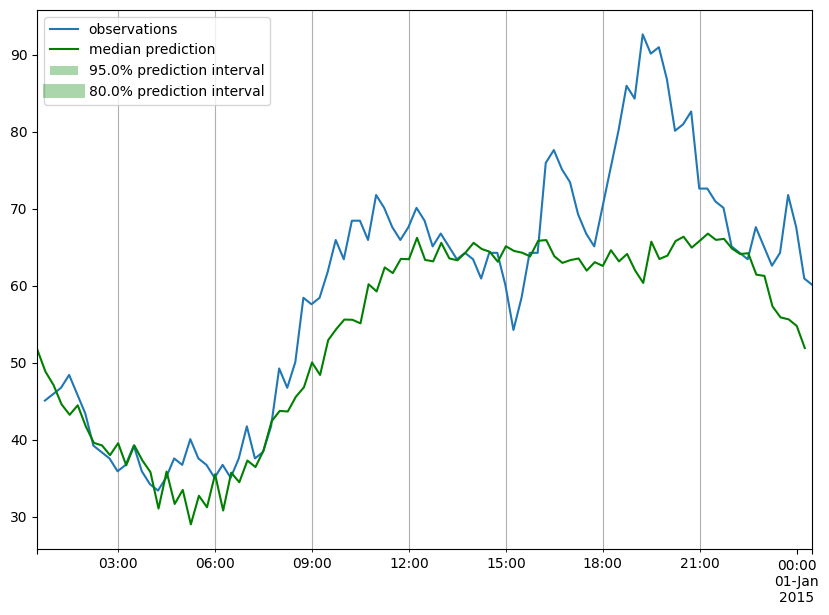

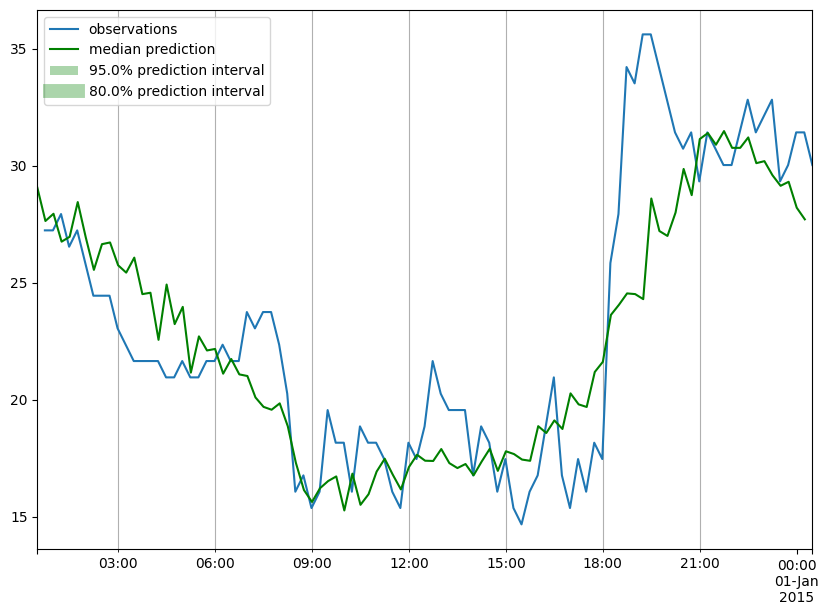

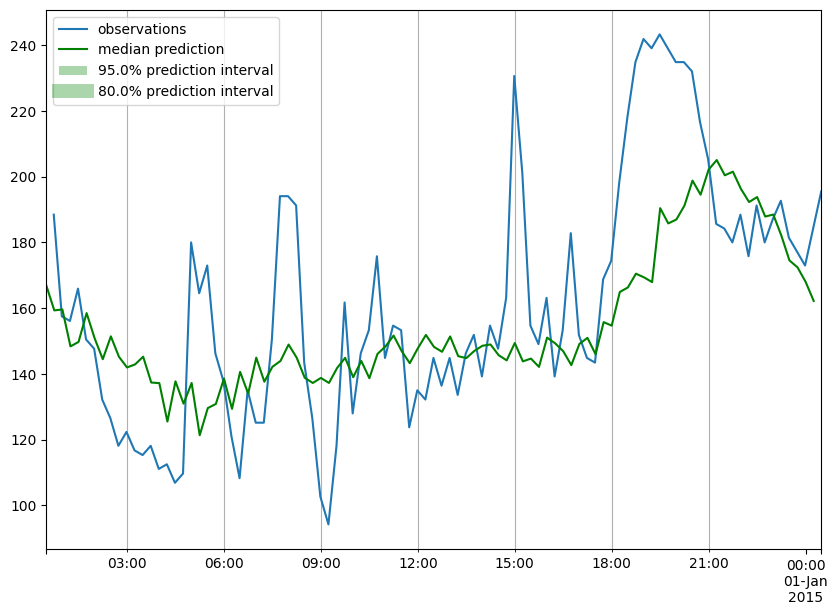

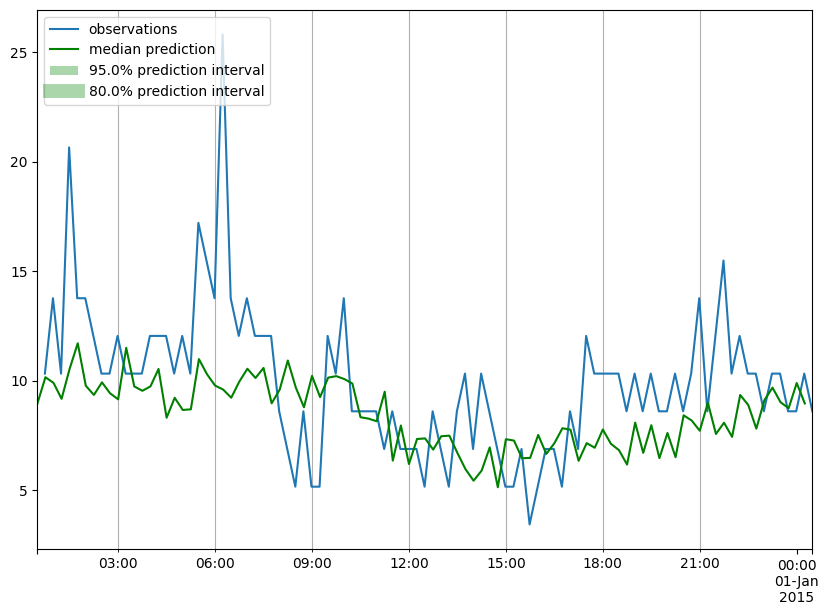

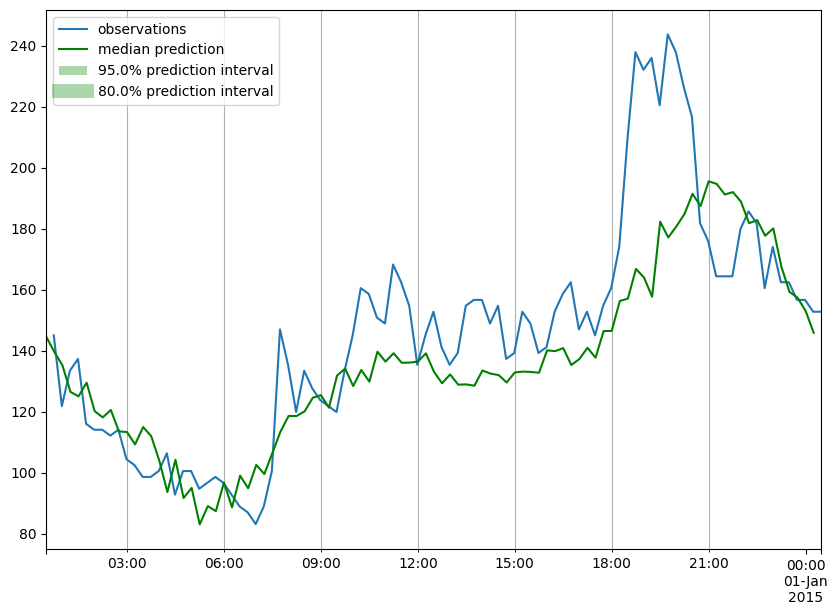

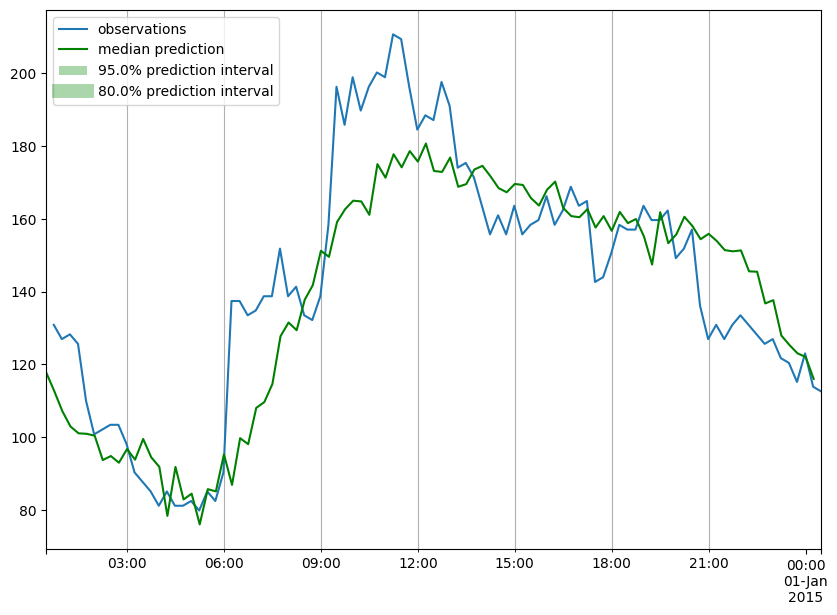

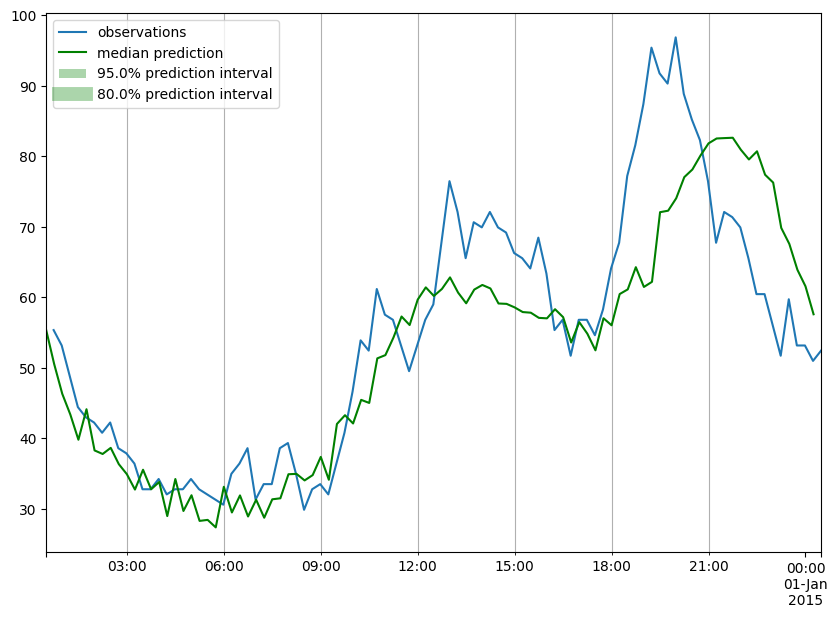

In [23]:
# plot the predictions for certain range of households from predictions
for i in tqdm(range(39)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry)

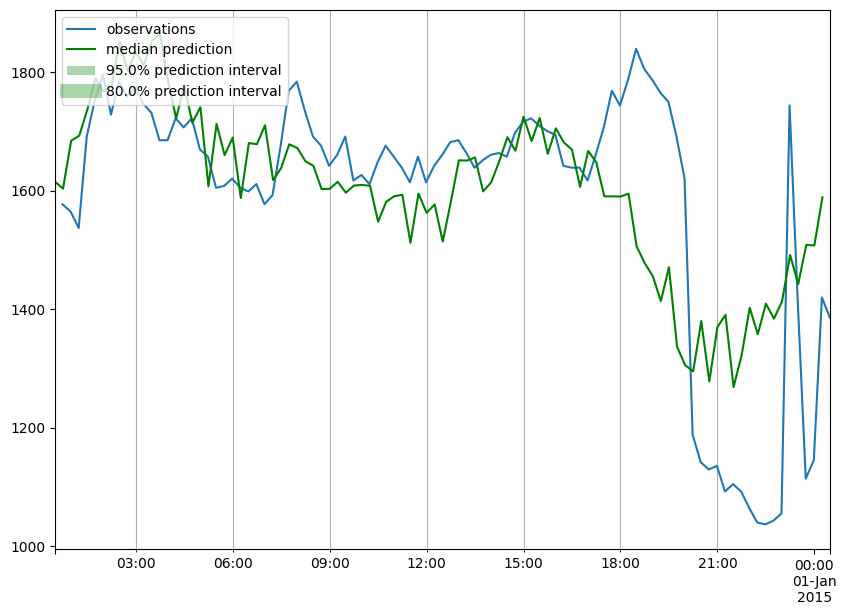

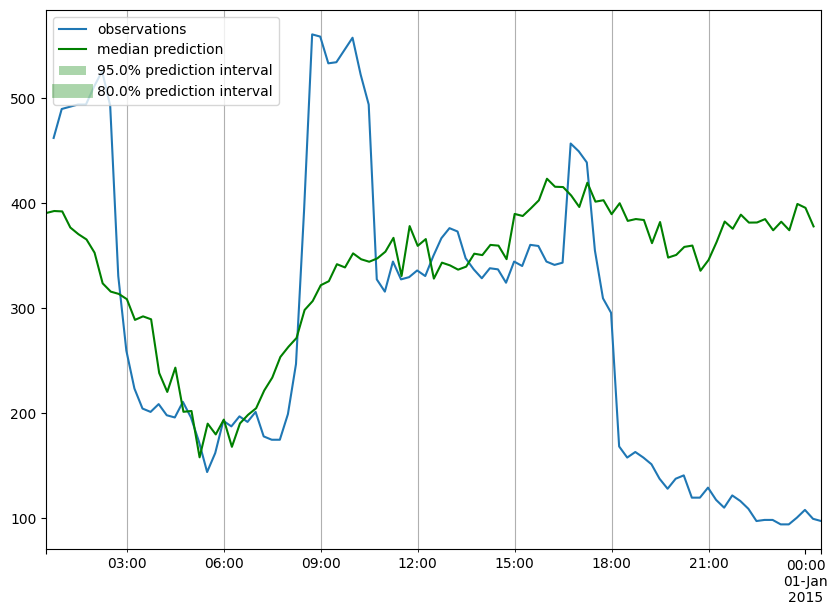

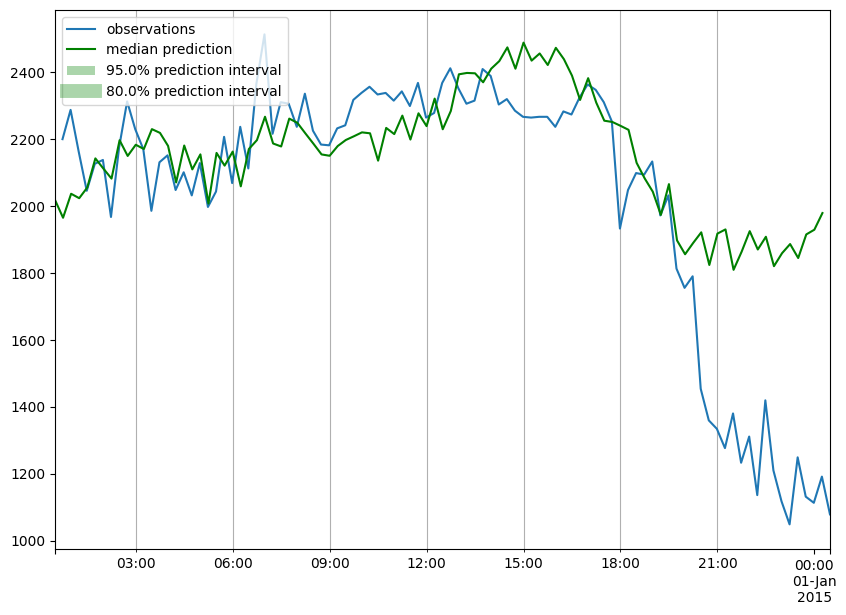

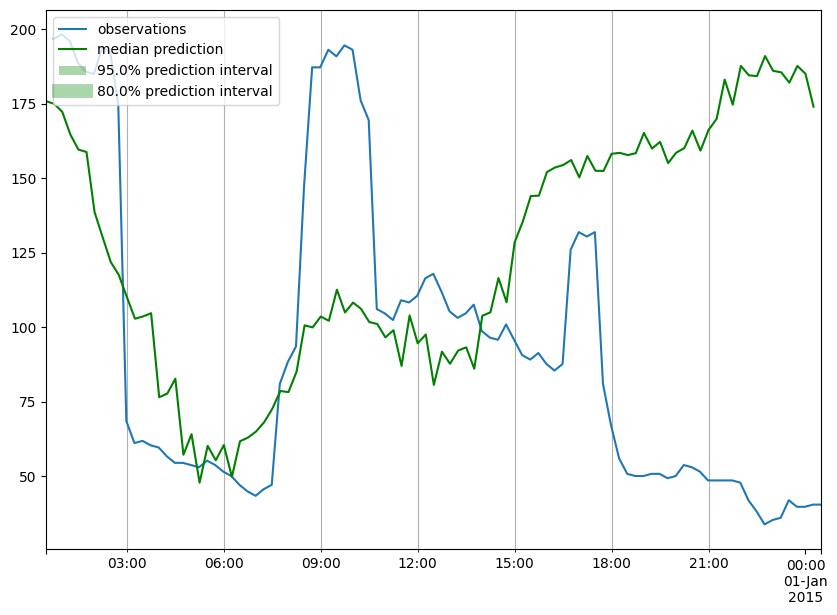

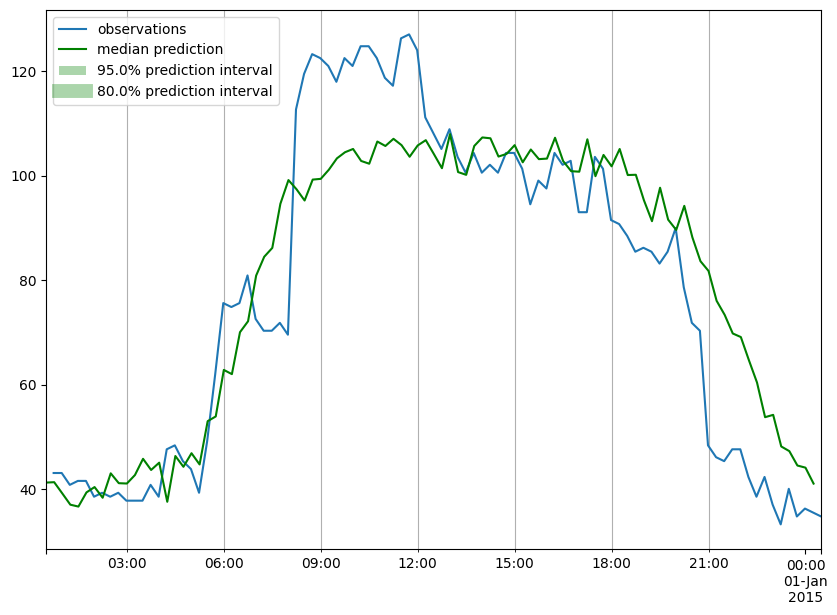

In [24]:
for i in range(160,165):
      ts_entry = tss[i]
      forecast_entry = forecasts[i]
      plot_prob_forecasts(ts_entry, forecast_entry)

In [25]:
#Utilise default library from gluonTS for evaluating the perfromance of the model
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(electric_test[0:369]))

Running evaluation: 100%|██████████| 369/369 [00:00<00:00, 7696.70it/s]
/usr/local/lib/python3.9/dist-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [26]:
item_metrics.columns

Index(['item_id', 'forecast_start', 'MSE', 'abs_error', 'abs_target_sum',
       'abs_target_mean', 'seasonal_error', 'MASE', 'MAPE', 'sMAPE', 'ND',
       'MSIS', 'QuantileLoss[0.1]', 'Coverage[0.1]', 'QuantileLoss[0.2]',
       'Coverage[0.2]', 'QuantileLoss[0.3]', 'Coverage[0.3]',
       'QuantileLoss[0.4]', 'Coverage[0.4]', 'QuantileLoss[0.5]',
       'Coverage[0.5]', 'QuantileLoss[0.6]', 'Coverage[0.6]',
       'QuantileLoss[0.7]', 'Coverage[0.7]', 'QuantileLoss[0.8]',
       'Coverage[0.8]', 'QuantileLoss[0.9]', 'Coverage[0.9]'],
      dtype='object')

In [27]:
#Calculate RMSE Values
item_metrics['RMSE']=np.sqrt(item_metrics['MSE'])

In [28]:
# Calculation of NRMSE for each predicted time series
item_metrics['NRMSE']=item_metrics['RMSE']/item_metrics['abs_target_mean']

In [29]:
# number of time series with less than 0.4 nrmse
item_metrics[item_metrics['NRMSE']<0.4].count()

item_id                0
forecast_start       312
MSE                  312
abs_error            312
abs_target_sum       312
abs_target_mean      312
seasonal_error       312
MASE                 312
MAPE                 312
sMAPE                312
ND                   312
MSIS                 312
QuantileLoss[0.1]    312
Coverage[0.1]        312
QuantileLoss[0.2]    312
Coverage[0.2]        312
QuantileLoss[0.3]    312
Coverage[0.3]        312
QuantileLoss[0.4]    312
Coverage[0.4]        312
QuantileLoss[0.5]    312
Coverage[0.5]        312
QuantileLoss[0.6]    312
Coverage[0.6]        312
QuantileLoss[0.7]    312
Coverage[0.7]        312
QuantileLoss[0.8]    312
Coverage[0.8]        312
QuantileLoss[0.9]    312
Coverage[0.9]        312
RMSE                 312
NRMSE                312
dtype: int64

In [30]:
# number of time series with less than 0.4 nrmse
item_metrics[item_metrics['NRMSE']>0.4].count()

item_id               0
forecast_start       57
MSE                  57
abs_error            57
abs_target_sum       57
abs_target_mean      57
seasonal_error       57
MASE                 57
MAPE                 55
sMAPE                57
ND                   57
MSIS                 57
QuantileLoss[0.1]    57
Coverage[0.1]        57
QuantileLoss[0.2]    57
Coverage[0.2]        57
QuantileLoss[0.3]    57
Coverage[0.3]        57
QuantileLoss[0.4]    57
Coverage[0.4]        57
QuantileLoss[0.5]    57
Coverage[0.5]        57
QuantileLoss[0.6]    57
Coverage[0.6]        57
QuantileLoss[0.7]    57
Coverage[0.7]        57
QuantileLoss[0.8]    57
Coverage[0.8]        57
QuantileLoss[0.9]    57
Coverage[0.9]        57
RMSE                 57
NRMSE                57
dtype: int64

In [31]:
# Calculation of normalised deviation for all time series
agg_metrics['ND']

0.18344941891167546

In [47]:
# Exporting the data to csv for further analysis in power bi.
item_metrics.to_csv('NBeats_Electricity_Results_Final.csv')